### Gamma family distributions

In [1]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [10]:
with open('gamma.stan', 'r') as file:
    print(file.read())

data 
{
    real alpha;
    real beta;
}

generated quantities 
{
    real gamma_y = gamma_rng(alpha, beta);
    real invgamma_y = invgamma_rng(alpha, beta);
}


In [12]:
gammmaDist=stan_utility.compile_model('gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_daf8c2fdd13f333ed02c79bd7d86e5f0 NOW.


In [19]:
R=1000
alpha=3
beta=1
gamma_sim=gammmaDist.sampling(data={'alpha':alpha, 'beta':beta},algorithm="Fixed_param", iter=R, warmup=0, 
                            chains=1, refresh=R, seed=29042020)

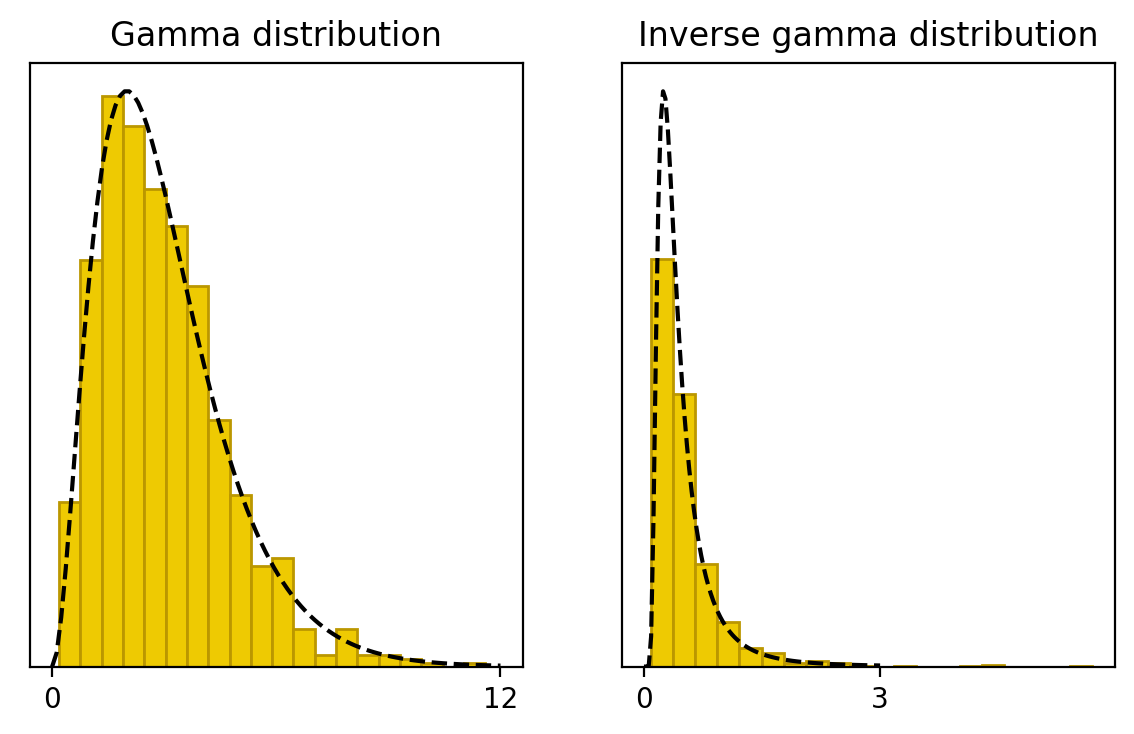

In [28]:
params=gamma_sim.extract()
gamma_y=params['gamma_y']
invgamma_y=params['invgamma_y']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(gamma_y,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,12,100)
ax1.plot(x,stats.gamma.pdf(x, a=alpha, scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([0,12])
ax1.set_yticks([])
ax1.set_title('Gamma distribution')

ax2=axes[1]
ax2.hist(invgamma_y,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,3,100)
ax2.plot(x,stats.invgamma.pdf(x, a=alpha, scale=1/beta),color='black',linestyle='--')
ax2.set_xticks([0,3])
ax2.set_yticks([])
ax2.set_title('Inverse gamma distribution')

plt.show()


In [53]:
with open('gamma_solver.stan', 'r') as file:
    print(file.read())
gamma_solver=stan_utility.compile_model('gamma_solver.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e721914c97c717e399c24b47a08c3f95 NOW.


functions 
{
    vector gamma_delta(vector y, vector theta, real[] x_r, int[] x_i) 
    {
        vector[3] deltas;
        deltas[1] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.98;
        deltas[2] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.98;
        deltas[3] = exp(y[1])/exp(y[2]) - 7.5;
        return deltas;
    }
}

data 
{
    vector[3] y_guess;
    vector[2] theta;
}

transformed data 
{
    vector[3] y;
    real x_r[0];
    int x_i[0];

    y = algebra_solver(gamma_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-1, 1e4);
}

generated quantities 
{
    real gamma_y = gamma_rng(exp(y[1]), exp(y[2]));
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}




In [54]:
data=dict(y_guess=[1,1,1],theta=[5, 10])
solved_values = gamma_solver.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
alpha = np.round(solved_values.extract()['alpha'][0])
beta = np.round(solved_values.extract()['beta'][0])
print(alpha, beta)

52.0 7.0


0.9850206791962464


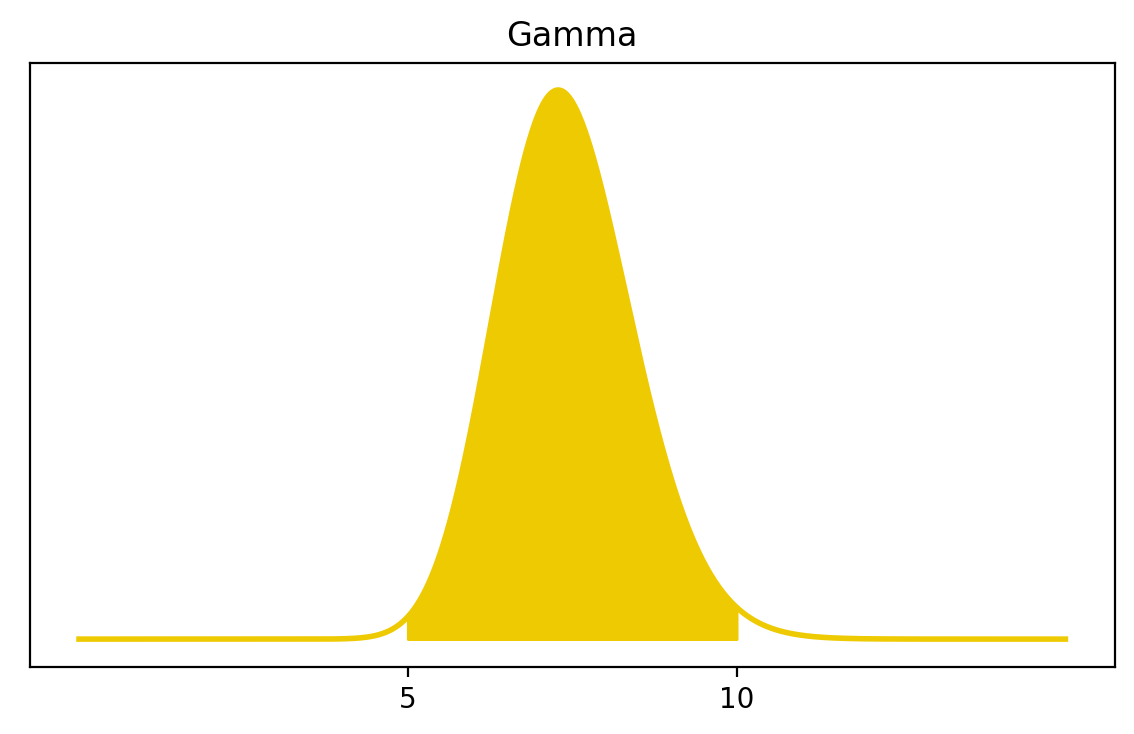

In [63]:
print(stats.gamma.cdf(10, a=alpha, scale=1/beta) - stats.gamma.cdf(5, a=alpha, scale=1/beta))
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,15,1000)
x4=np.linspace(5,10,1000)
ax2.plot(x2,stats.gamma.pdf(x2, a=alpha, scale=1/beta),color=dark,linewidth=2)
ax2.fill_between(x4,stats.gamma.pdf(x4, a=alpha, scale=1/beta),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([5,10])
ax2.set_title('Gamma')
plt.show()

In [114]:
with open('inverse_gamma_solver.stan', 'r') as file:
    print(file.read())
gamma_solver=stan_utility.compile_model('inverse_gamma_solver.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2afbdd28db0a67fdcc95d4f7f3383209 NOW.


functions 
{
    vector inv_gamma_delta(vector y, vector theta, real[] x_r, int[] x_i) 
    {
        vector[3] deltas;
        deltas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - y[3];
        deltas[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - (0.98+y[3]);
        deltas[3] = (y[3]+(1-inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2]))))-0.02;
        return deltas;
    }
}

data 
{
    vector[3] y_guess;
    vector[2] theta;
}

transformed data 
{
    vector[3] y;
    real x_r[0];
    int x_i[0];

    y = algebra_solver(inv_gamma_delta, y_guess, theta, x_r, x_i, 1e-10, 0.01, 1e6);
}

generated quantities 
{
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}




In [163]:
data=dict(y_guess=[1.0039, 2, 0.001],theta=[5, 10])
solved_values = gamma_solver.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
alpha = (solved_values.extract()['alpha'][0])
beta = (solved_values.extract()['beta'][0])
print(alpha, beta)

43.22960121551086 298.27015690816467


0.0


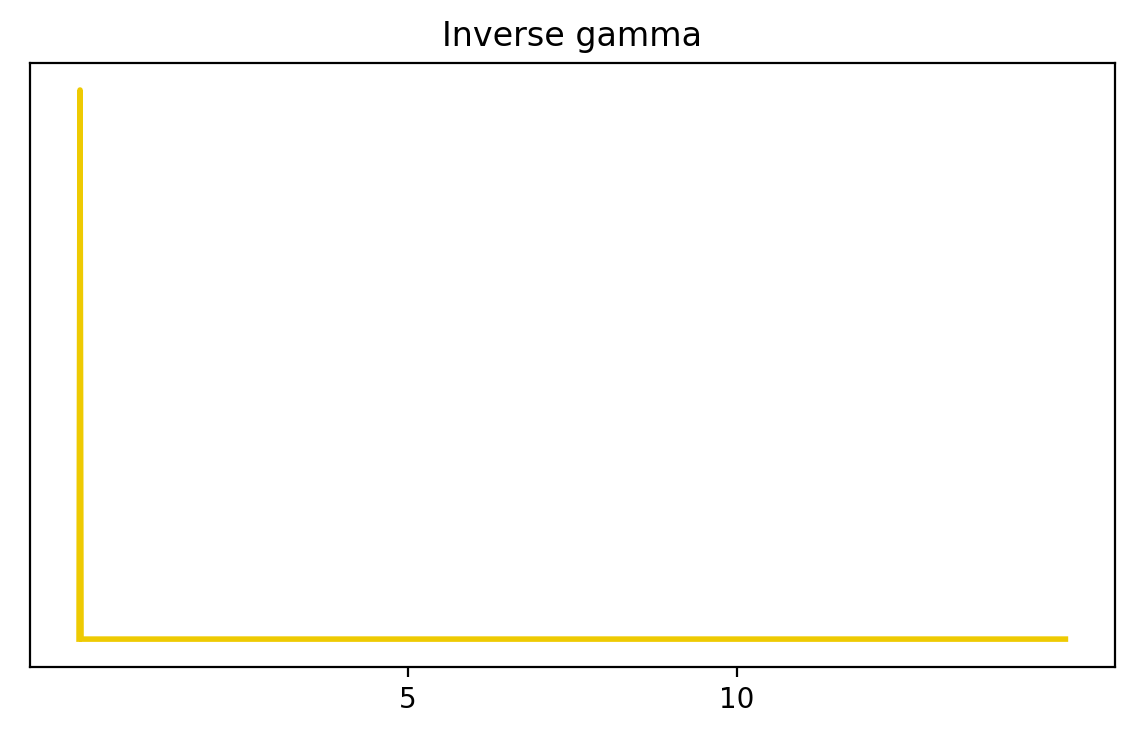

In [164]:
print(stats.invgamma.cdf(10, a=alpha, scale=1/beta) - stats.invgamma.cdf(5, a=alpha, scale=1/beta))
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,15,1000)
x4=np.linspace(5,10,1000)
ax2.plot(x2,stats.invgamma.pdf(x2, a=alpha, scale=1/beta),color=dark,linewidth=2)
ax2.fill_between(x4,stats.invgamma.pdf(x4, a=alpha, scale=1/beta),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([5,10])
ax2.set_title('Inverse gamma')
plt.show()

I tried many possible functions for inv_gamma_delta to calculate deltas, but wasn't able to get any solution that made any sense. Most of the times algebra_solver wasn't able to find any solution.

### Negative binomial distribution

Concentration parametrization

data 
{
    real alpha;
    real beta;
}

generated quantities 
{
    real neg_bi_y = neg_binomial_rng(alpha, beta);
    real poisson_y = poisson_rng(alpha/beta);
}
Using cached StanModel


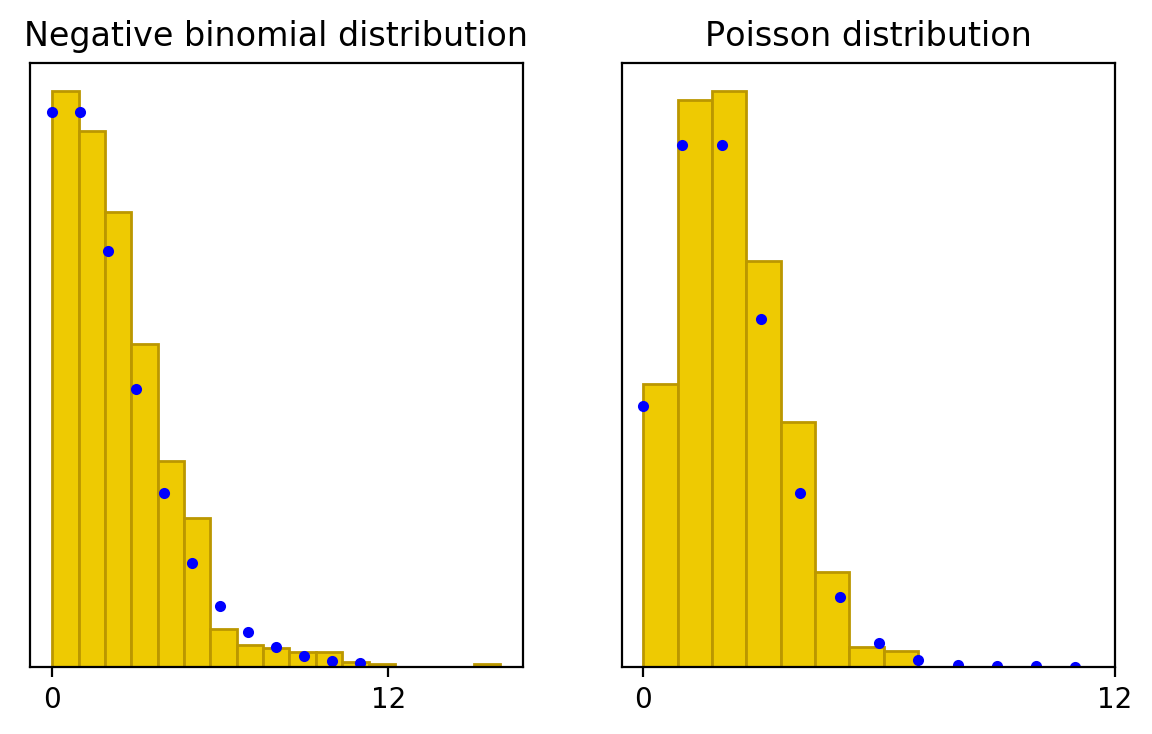

In [198]:
with open('concentration_neg_bi.stan', 'r') as file:
    print(file.read())
negBiDist=stan_utility.compile_model('concentration_neg_bi.stan')
R=1000
alpha=2
beta=1
negBi_sim=negBiDist.sampling(data={'alpha':alpha, 'beta':beta},algorithm="Fixed_param", iter=R, warmup=0, 
                            chains=1, refresh=R, seed=29042020)
params=negBi_sim.extract()
negBi_y=params['neg_bi_y']
poisson_y=params['poisson_y']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(negBi_y,bins=17,color=dark,edgecolor=dark_highlight,density=True)
x=np.arange(0,12,1)
ax1.plot(x,stats.nbinom.pmf(x, n=alpha, p=(beta/(beta+1))), 'bo', markersize=3)
ax1.set_xticks([0,12])
ax1.set_yticks([])
ax1.set_title('Negative binomial distribution')

ax2=axes[1]
ax2.hist(poisson_y,bins=8,color=dark,edgecolor=dark_highlight,density=True)
x=np.arange(0,12,1)
ax2.plot(x,stats.poisson.pmf(x, alpha/beta), 'bo', markersize=3)
ax2.set_xticks([0,12])
ax2.set_yticks([])
ax2.set_title('Poisson distribution')

plt.show()

Dispersion parametrization

data 
{
    real mu;
    real phi;
}

generated quantities 
{
    real neg_bi_y = neg_binomial_2_rng(mu, phi);
    real poisson_y = poisson_rng(mu);
}
Using cached StanModel


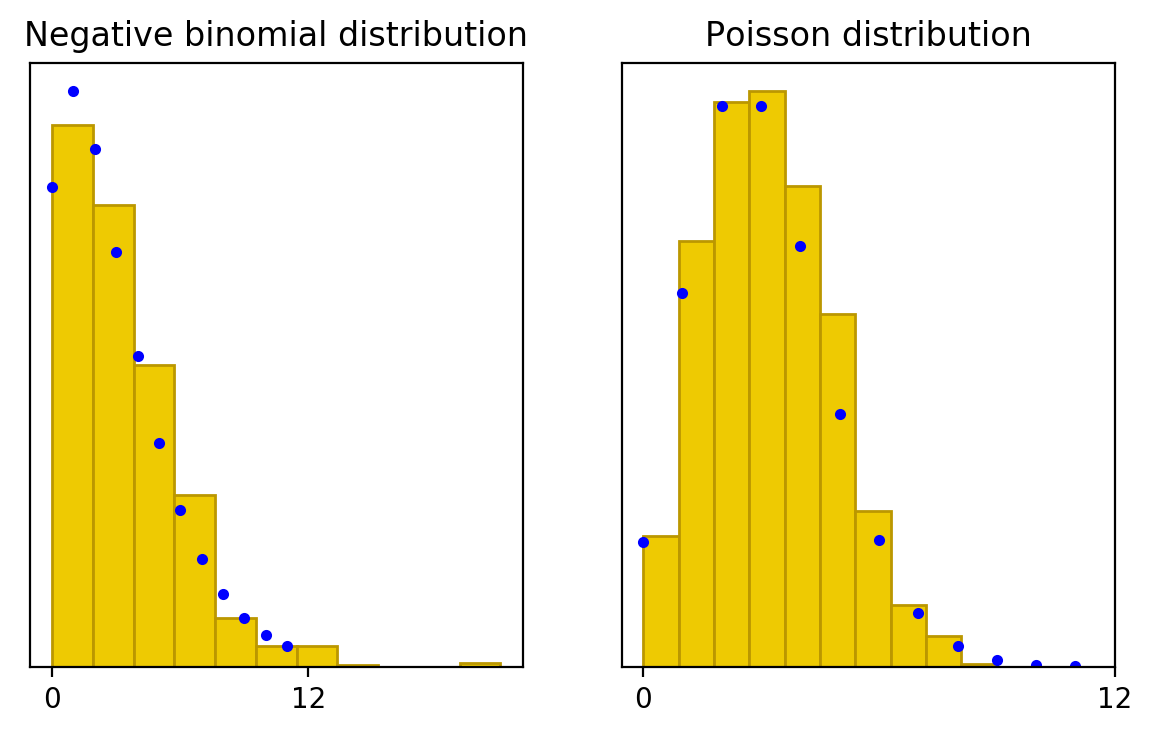

In [215]:
with open('disp_neg_bi.stan', 'r') as file:
    print(file.read())
negBiDist=stan_utility.compile_model('disp_neg_bi.stan')
R=1000
mu=3
phi=2
negBi_sim=negBiDist.sampling(data={'mu':mu, 'phi':phi},algorithm="Fixed_param", iter=R, warmup=0, 
                            chains=1, refresh=R, seed=29042020)
params=negBi_sim.extract()
negBi_y=params['neg_bi_y']
poisson_y=params['poisson_y']

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(negBi_y,bins=11,color=dark,edgecolor=dark_highlight,density=True)
x=np.arange(0,12,1)
ax1.plot(x,stats.nbinom.pmf(x, n=phi, p=(phi/(mu+phi))), 'bo', markersize=3)
ax1.set_xticks([0,12])
ax1.set_yticks([])
ax1.set_title('Negative binomial distribution')

ax2=axes[1]
ax2.hist(poisson_y,bins=10,color=dark,edgecolor=dark_highlight,density=True)
x=np.arange(0,12,1)
ax2.plot(x,stats.poisson.pmf(x, mu), 'bo', markersize=3)
ax2.set_xticks([0,12])
ax2.set_yticks([])
ax2.set_title('Poisson distribution')

plt.show()

### Student-t family distributions

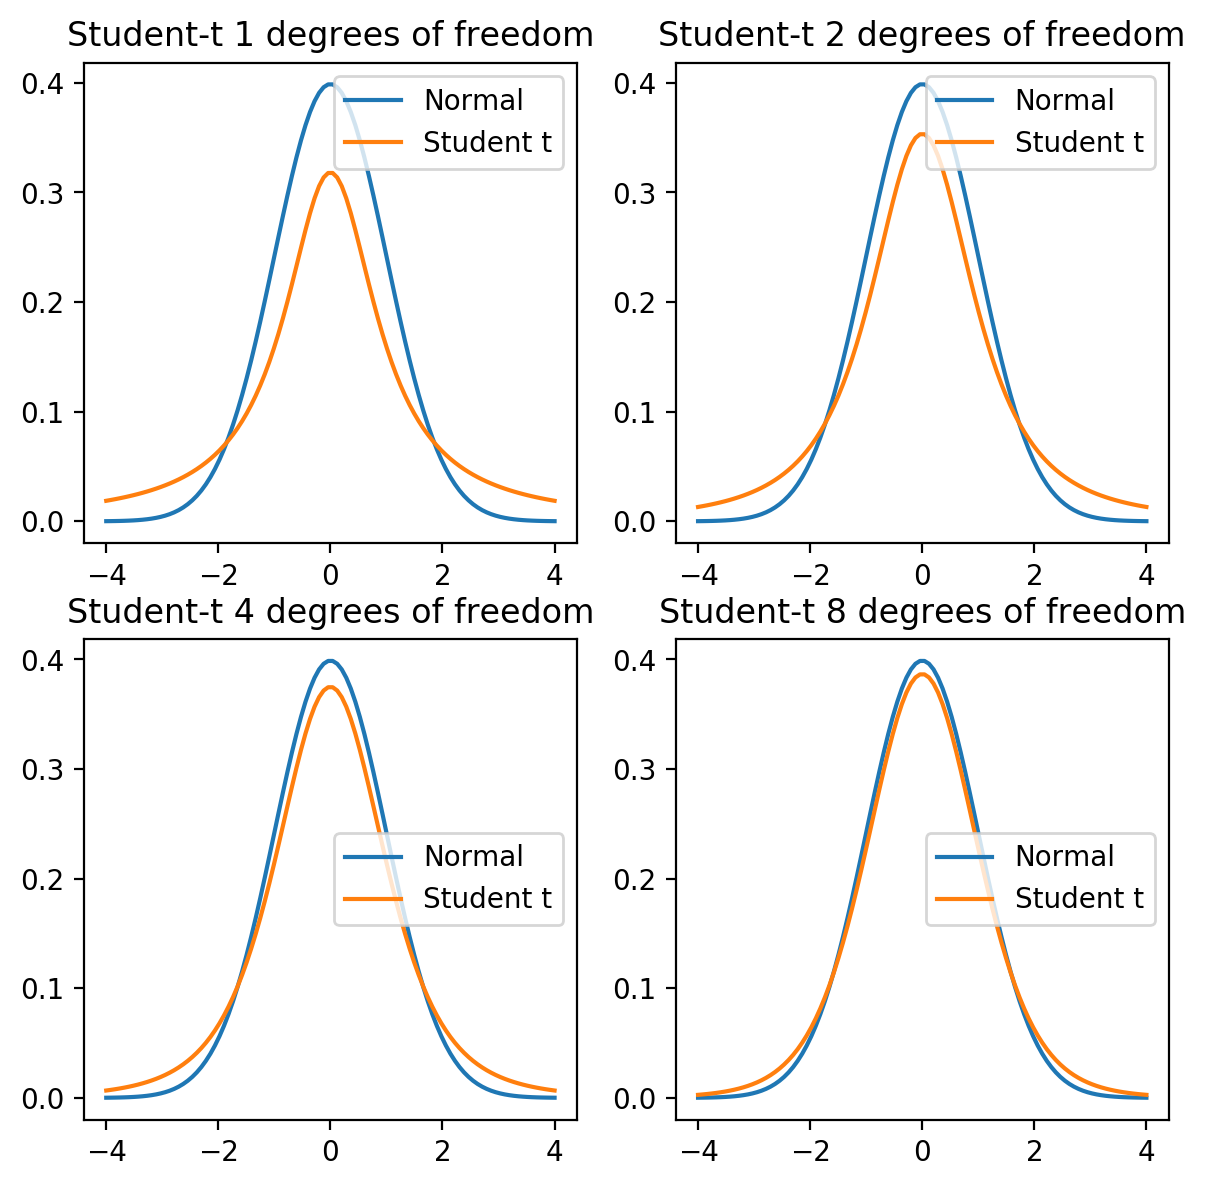

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

dof = [1,2,4,8]
x=np.linspace(-4, 4 ,100)

for i in range(0,4):
    
    axes[int(i/2)][i%2].plot(x,stats.norm.pdf(x))
    axes[int(i/2)][i%2].plot(x,stats.t.pdf(x, df=dof[i]))
    axes[int(i/2)][i%2].set_title('Student-t ' + str(dof[i]) + ' degrees of freedom')
    axes[int(i/2)][i%2].legend(["Normal", "Student t"])

plt.show()

data 
{
    real nu;
    real mu;
    real sigma;
}

generated quantities 
{
    real studentt_y = student_t_rng(nu, mu, sigma);
}
Using cached StanModel


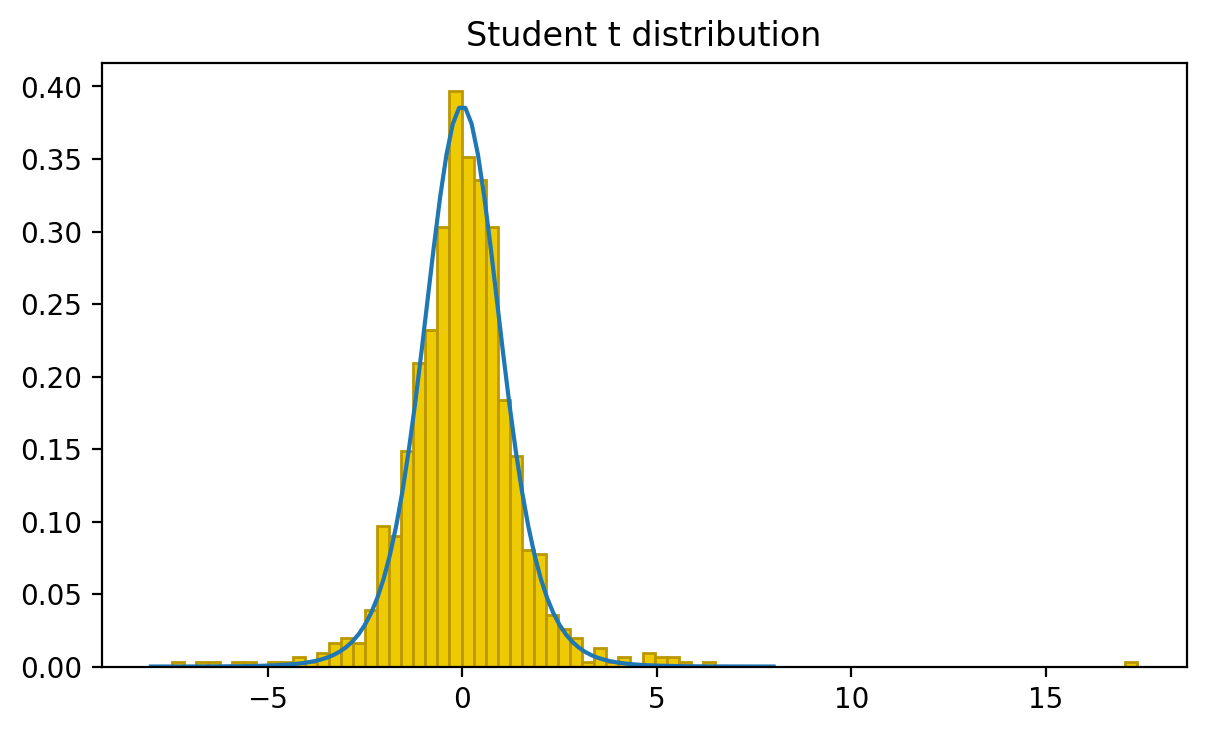

In [40]:
with open('studentt.stan', 'r') as file:
    print(file.read())
studenttDist=stan_utility.compile_model('studentt.stan')
R=1000
nu=4
mu=0
sigma=1
studentt_sim=studenttDist.sampling(data={'nu':nu, 'mu':mu, 'sigma':sigma},algorithm="Fixed_param", iter=R, warmup=0, 
                            chains=1, refresh=R, seed=29042020)
params=studentt_sim.extract()
studentt_y=params['studentt_y']

fig, axes = plt.subplots(1, 1, figsize=(7, 4))

ax1=axes
ax1.hist(studentt_y,bins=80,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(-8, 8 ,100)
ax1.plot(x,stats.t.pdf(x, df=dof[i]))
ax1.set_title('Student t distribution')

plt.show()

### Multivariate normal distributions